In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import os

from utils import *
from model import *

In [2]:
paths = {
    'mirna_df': 'data/our_data/nodes/mirnas.tsv',
    'disease_df': 'data/our_data/nodes/diseases.tsv',
    'mrna_df': 'data/our_data/nodes/mrnas.tsv',
    'mda': 'data/our_data/edges/mirna_disease_rnadisease.tsv',
    'train_val_test': 'data/our_data/train_val_test_with_9block_test_sparse.npy',
    'graph_without_mid': 'data/our_data/data_without_mid.pt',
    'graph_feature_randn_without_mid': 'data/our_data/data_feature_randn_without_mid.pt',
    'model_save_folder': 'files/models/',
    'model_save_path': ''
}

# Load Trained Model

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cuda:1'


In [3]:
settings_and_weights = torch.load('files/models/egpmda_0.pth')
settings = settings_and_weights['settings']
model = Model(k=settings['k'], dim=settings['dim'], num_heads=settings['num_heads'], num_layers=settings['num_layers'],
                group_type=settings['group_type'], feature_ablation_type=settings['feature_ablation_type']).to(device)
model.load_state_dict(settings_and_weights['best_weights'])

posi_edge_index, nega_edge_index, _ = get_edge_index(paths=paths, settings=settings, modes=settings['train_modes'])
data = get_data(path=paths[settings['which_graph']], posi_edge_index=posi_edge_index)

settings['test_nega_ratio'] = 100
pred, label, sparse_edge_label_index = evaluate(data, paths, settings, device, model)
# np.save('files/models/pred_0', pred)

AUC, AUPR, ACC, P, R, F1, threshold = get_metrics(label, pred, 0.5)
sparse_list = get_sparse_r(pred, sparse_edge_label_index, 0.5)

0.953 0.306 0.951 0.142 0.775 0.24
0.238 0.0 0.164 0.0 0.681 0.64 0.94


# Plot - Recall@5%

In [3]:
def get_mirna_disease_index(mirna_id, disease_id, posi_samples):
    
    mid_df = pd.DataFrame({
        'mirna': [tmp_sample[0] for tmp_sample in posi_samples],
        'disease': [tmp_sample[1] for tmp_sample in posi_samples]
    })
    
    mirna_index = pd.merge(mid_df['mirna'], mirna_id, left_on='mirna', right_on='mirna_id', how='left')['mapped_index'].values
    disease_index = pd.merge(mid_df['disease'], disease_id, left_on='disease', right_on='disease_id', how='left')['mapped_index'].values
    
    return mirna_index, disease_index

In [4]:
def plot_pred_posi_samples(all_posi_samples, test_posi_samples, pred_posi_samples):
    
    mirna_ids = pd.read_table(paths['mirna_df'])['Accession']
    train_val_mirna_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['ID1']).agg('count').sort_values('Year', ascending=False)
    train_val_mirna_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
    mirna_ids = train_val_mirna_degree.index.to_list() + list(set(mirna_ids.to_list()) - set(train_val_mirna_degree.index))
    mirna_id = pd.DataFrame(data={
        'mirna_id': mirna_ids,
        'mapped_index': pd.RangeIndex(len(mirna_ids))
    })

    disease_ids = pd.read_table(paths['disease_df'])['ID']
    train_val_disease_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['MeSH ID']).agg('count').sort_values('Year', ascending=False)
    train_val_disease_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
    disease_ids = train_val_disease_degree.index.to_list() + list(set(disease_ids.to_list()) - set(train_val_disease_degree.index))
    disease_id = pd.DataFrame(data={
        'disease_id': disease_ids,
        'mapped_index': pd.RangeIndex(len(disease_ids))
    })

    test_mirna_index, test_disease_index = get_mirna_disease_index(mirna_id, disease_id, test_posi_samples)
    pred_mirna_index, pred_disease_index = get_mirna_disease_index(mirna_id, disease_id, pred_posi_samples)

    # plt.figure(figsize=(len(disease_ids) / 100, len(mirna_ids) / 100), dpi=600)
    plt.figure(figsize=(len(disease_ids) / 100, len(mirna_ids) / 100))
    plt.axis([0, len(disease_ids), 0, len(mirna_ids)])
    # TestL Blue
    plt.scatter(test_disease_index, test_mirna_index, c='b', s=2)
    # Pred: Red
    plt.scatter(pred_disease_index, pred_mirna_index, c='r', s=2)

    hline_0 = len(train_val_mirna_degree.index)
    hline_m = len(train_val_mirna_degree[train_val_mirna_degree['Degree'] > 8].index)
    v_top = len(disease_ids)
    plt.hlines(hline_0, 0, v_top, colors='black')
    plt.hlines(hline_m, 0, v_top, colors='black')
    vline_0 = len(train_val_disease_degree.index)
    vline_m = len(train_val_disease_degree[train_val_disease_degree['Degree'] > 10].index)
    h_top = len(mirna_ids)
    plt.vlines(vline_0, 0, h_top, colors='black')
    plt.vlines(vline_m, 0, h_top, colors='black')

    font_text = {
        'family' : 'Times New Roman',
        'weight' : 'normal',
        'size' : 28
    }

    plt.text((0 + vline_m) / 2, (hline_0 + h_top) / 2, '0-M: 21', fontdict=font_text, ha='center', va='center')
    plt.text((0 + vline_m) / 2, (hline_m + hline_0) / 2, 'L-M: 1564', fontdict=font_text, ha='center', va='center')
    plt.text((0 + vline_m) / 2, (0 + hline_m) / 2, 'M-M: 6876', fontdict=font_text, ha='center', va='center')

    plt.text((vline_m + vline_0) / 2, (hline_0 + h_top) / 2, '0-L: 0', fontdict=font_text, ha='center', va='center')
    plt.text((vline_m + vline_0) / 2, (hline_m + hline_0) / 2, 'L-L: 133', fontdict=font_text, ha='center', va='center')
    plt.text((vline_m + vline_0) / 2, (0 + hline_m) / 2, 'M-L: 1312', fontdict=font_text, ha='center', va='center')
    
    plt.text((vline_0 + v_top) / 2, (hline_0 + h_top) / 2, '0-0: 0', fontdict=font_text, ha='center', va='center')
    plt.text((vline_0 + v_top) / 2, (hline_m + hline_0) / 2, 'L-0: 57', fontdict=font_text, ha='center', va='center')
    plt.text((vline_0 + v_top) / 2, (0 + hline_m) / 2, 'M-0: 1076', fontdict=font_text, ha='center', va='center')

    plt.text((0 + vline_m) / 2, h_top + 20, 'Diseases\nMore Known', fontdict=font_text, ha='center', va='bottom')
    plt.text((vline_m + vline_0) / 2, h_top + 20, 'Diseases\nLess Known', fontdict=font_text, ha='center', va='bottom')
    plt.text((vline_0 + v_top) / 2, h_top + 20, 'Diseases\nZero Known', fontdict=font_text, ha='center', va='bottom')

    plt.text(v_top + 20, (hline_0 + h_top) / 2, 'MiRNAs\nZero Known', fontdict=font_text, ha='left', va='center')
    plt.text(v_top + 20, (hline_m + hline_0) / 2, 'MiRNAs\nLess Known', fontdict=font_text, ha='left', va='center')
    plt.text(v_top + 20, (0 + hline_m) / 2, 'MiRNAs\nMore Known', fontdict=font_text, ha='left', va='center')

    font_label = {
        'family' : 'Times New Roman',
        'weight' : 'normal',
        'size' : 36
    }
    plt.xlabel('Diseases', font_label)
    plt.ylabel('MiRNAs', font_label)
    plt.legend(['Test samples', 'Predicted positive samples'], loc='upper right', prop=font_label, markerscale=10)

    plt.show()

In [5]:
mda = pd.read_table(paths['mda'])
mda = mda[['ID1', 'MeSH ID', 'Year']]
all_posi_samples = mda.groupby(['ID1', 'MeSH ID']).agg({'Year': min})

train_val_test = np.load(paths['train_val_test'], allow_pickle=True).item()
test_samples = train_val_test['test']['posi'] + train_val_test['test']['nega']

labels = [1] * len(train_val_test['test']['posi']) + [0] * len(train_val_test['test']['nega'])

0.547
Recall: 0.757
55747


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


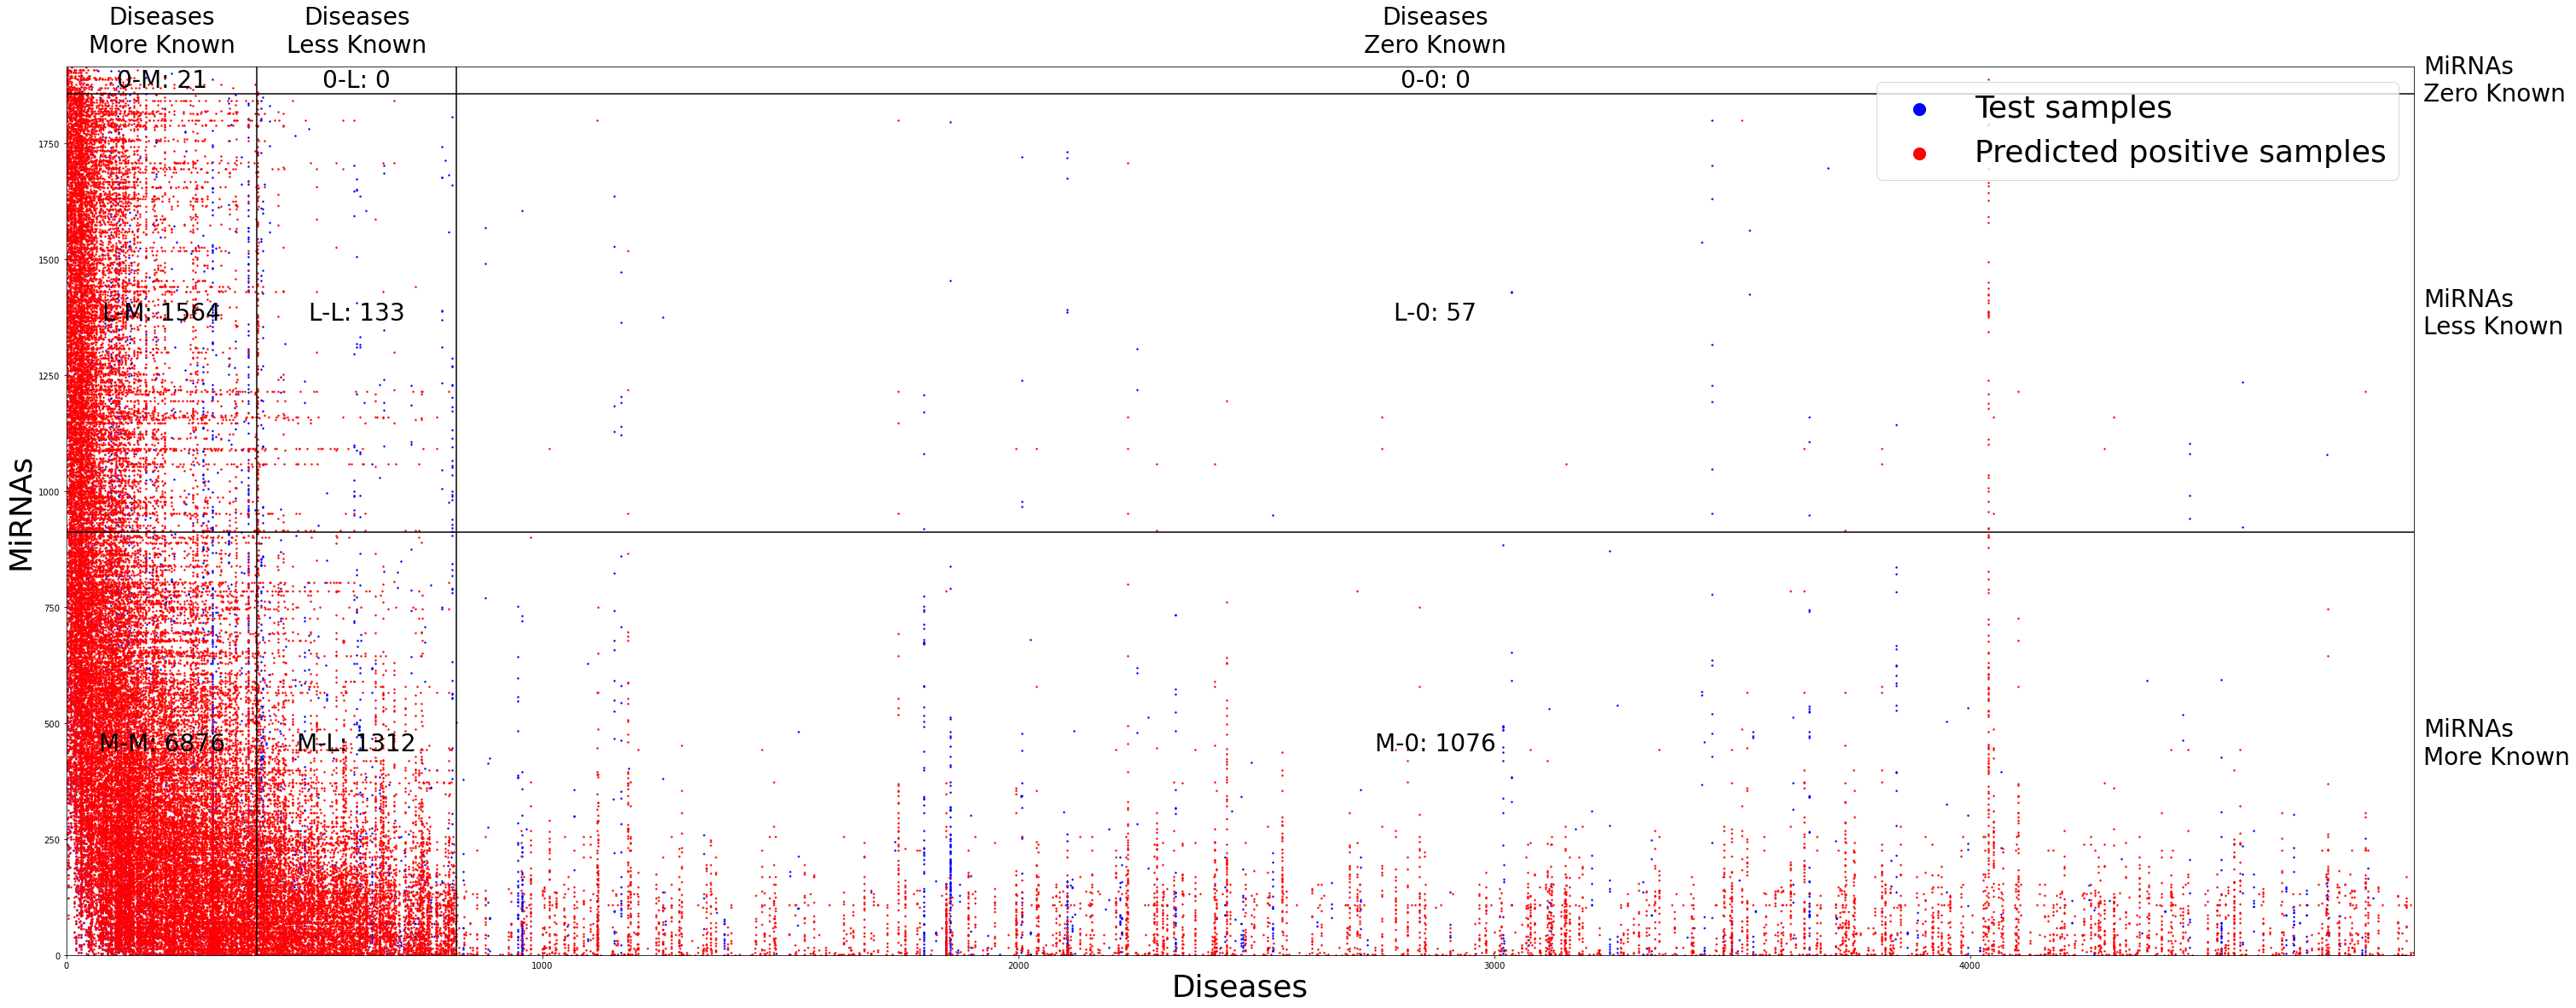

In [6]:
preds = np.load('files/models/pred_0.npy')

threshold = np.percentile(preds, 95)
# threshold = 0.5
print(threshold.round(3))

top_n_preds = np.array([1 if p > threshold else 0 for p in preds])
R = recall_score(labels, top_n_preds)
print('Recall:', round(R, 3))

test_posi_samples = train_val_test['test']['posi']
pred_posi_samples = np.array(test_samples)[preds > threshold]
print(len(pred_posi_samples))

plot_pred_posi_samples(all_posi_samples, test_posi_samples, pred_posi_samples)

# Attention value for each meta-relation: $\mu$

In [8]:
p_rel_mean = dict()

for repeat in range(5):
    parameters = torch.load('files/models/egpmda_' + str(repeat) + '.pth')['best_weights']
    for key in parameters.keys():
        if 'p_rel' in key:
            if key not in p_rel_mean.keys():
                p_rel_mean[key] = []
                p_rel_mean[key].append(parameters[key].cpu().numpy().mean())
                # print(key, parameters[key].cpu().numpy().mean())
            else:
                p_rel_mean[key].append(parameters[key].cpu().numpy().mean())

for key in p_rel_mean.keys():
    print(key, np.mean(p_rel_mean[key]).round(3))

gnn.convs.0.p_rel.mirna__family__mirna 1.241
gnn.convs.0.p_rel.disease__fatherson__disease 1.056
gnn.convs.0.p_rel.mrna__group__mrna 0.889
gnn.convs.0.p_rel.mirna__association__mrna 0.989
gnn.convs.0.p_rel.mrna__association__disease 0.828
gnn.convs.0.p_rel.mrna__rev_association__mirna 1.005
gnn.convs.0.p_rel.disease__rev_association__mrna 0.796
gnn.convs.1.p_rel.mirna__family__mirna 1.082
gnn.convs.1.p_rel.disease__fatherson__disease 1.015
gnn.convs.1.p_rel.mrna__group__mrna 1.0
gnn.convs.1.p_rel.mirna__association__mrna 1.0
gnn.convs.1.p_rel.mrna__association__disease 0.957
gnn.convs.1.p_rel.mrna__rev_association__mirna 0.924
gnn.convs.1.p_rel.disease__rev_association__mrna 1.0


# Case Study

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cuda:1'


In [4]:
settings_and_weights = torch.load('files/models/egpmda_case_study.pth')
settings = settings_and_weights['settings']
model = Model(k=settings['k'], dim=settings['dim'], num_heads=settings['num_heads'], num_layers=settings['num_layers'],
                group_type=settings['group_type'], feature_ablation_type=settings['feature_ablation_type']).to(device)
model.load_state_dict(settings_and_weights['best_weights'])
settings

{'which_graph': 'graph_without_mid',
 'feature_ablation_type': 3,
 'feature_randn': False,
 'num_neighbors': [-1, -1, -1, -1],
 'k': 4,
 'dim': 64,
 'num_heads': 4,
 'num_layers': 2,
 'group_type': 'sum',
 'batch_size': 256,
 'epoch_num': 50,
 'lr': 0.001,
 'early_stop_type': 'self_fitting',
 'patience': 1,
 'train_modes': ['train', 'val', 'test'],
 'evaluate_modes': []}

In [ ]:
settings['test_nega_ratio'] = None
posi_edge_index, nega_edge_index, _ = get_edge_index(paths=paths, settings=settings, modes=settings['train_modes'])
data = get_data(path=paths[settings['which_graph']], posi_edge_index=posi_edge_index)

In [7]:
def get_adj(posi_samples):

    mirnas = pd.read_table(paths['mirna_df'])
    assert len(mirnas['Accession']) == len(mirnas['Accession'].unique())
    diseases = pd.read_table(paths['disease_df'])
    assert len(diseases['ID']) == len(diseases['ID'].unique())

    mid_adj = pd.DataFrame(
        index=mirnas['Accession'].drop_duplicates().values,
        columns=diseases['ID'].drop_duplicates().values
    )
    for mirna, disease in posi_samples.index:
        mid_adj.loc[mirna, disease] = 1

    mid_adj = mid_adj.fillna(0)
    
    return mid_adj

In [8]:
train_val_test = np.load(paths['train_val_test'], allow_pickle=True).item()

mda = pd.read_table(paths['mda'])
mda = mda[['ID1', 'MeSH ID', 'Year']]
all_posi_samples = mda.groupby(['ID1', 'MeSH ID']).agg({'Year': min})

mid_adj = get_adj(all_posi_samples)

all_nega_samples = []
for mirna, diseases in mid_adj.iterrows():
    all_nega_samples = all_nega_samples + [(mirna, disease) for disease in diseases[diseases == 0].index.values]

train_val_test['test']['nega'] = all_nega_samples

# np.save('data/our_data/train_val_test_case.npy', train_val_test)

In [ ]:
paths['train_val_test'] = 'data/our_data/train_val_test_case.npy'
settings['evaluate_modes'] = ['test']

# It runs for about 25 minutes... Be patient...
# We've saved the results in 'files/case_study/all_posi_pred.csv' and 'files/case_study/case_study.csv'
pred, label, sparse_edge_label_index = evaluate(data, paths, settings, device, model)

In [25]:
train_val_test = np.load(paths['train_val_test'], allow_pickle=True).item()
pred_df = pd.DataFrame({
    'pred': pred,
    'label': label,
    }, index = train_val_test['test']['posi'] + train_val_test['test']['nega']
)
pred_df

,pred,label
"(MI0000060, D000083242)",9.891802e-01,1.0
"(MI0000060, D000236)",9.458985e-01,1.0
"(MI0000060, D000795)",8.951137e-01,1.0
"(MI0000060, D001327)",9.819178e-01,1.0
"(MI0000060, D003922)",9.997485e-01,1.0
...,...,...
"(MI0041071, D066126)",3.687527e-05,0.0
"(MI0041071, D066166)",2.316070e-06,0.0
"(MI0041071, D066190)",3.655623e-11,0.0
"(MI0041071, D066253)",1.339125e-07,0.0


In [ ]:
posi_pred = pred_df[(pred_df['pred'] > 0.5) & (pred_df['label'] == 0)].sort_values(by='pred', ascending=False)

In [6]:
posi_pred = posi_pred.reset_index()
posi_pred.insert(loc=0, column='disease', value=pd.DataFrame(posi_pred['index'].tolist())[1])
posi_pred.insert(loc=0, column='miRNA', value=pd.DataFrame(posi_pred['index'].tolist())[0])
posi_pred = posi_pred.drop(labels='index', axis=1)
posi_pred

,miRNA,disease,pred,label
0,MI0000477,D057180,0.999994,0
1,MI0003643,D004938,0.999993,0
2,MI0000477,D054363,0.999993,0
3,MI0000454,D004938,0.999992,0
4,MI0003646,D004938,0.999992,0
...,...,...,...,...
502077,MI0000238,D018303,0.500007,0
502078,MI0003557,D017544,0.500007,0
502079,MI0014169,D017545,0.500003,0
502080,MI0000442,D010026,0.500000,0


In [23]:
mirnas = pd.read_table(paths['mirna_df'])[['Accession', 'ID', 'Mature1_ID', 'Mature2_ID']]
diseases = pd.read_table(paths['disease_df'])[['ID', 'Disease Name']]
diseases = diseases.rename(columns={'ID':'Disease ID'})

In [9]:
posi_pred = pd.merge(posi_pred, mirnas, left_on='miRNA', right_on='Accession', how='left').drop(labels='Accession', axis=1)
posi_pred = pd.merge(posi_pred, diseases, left_on='disease', right_on='Disease ID', how='left').drop(labels='Disease ID', axis=1)
posi_pred

,miRNA,disease,pred,label,ID,Mature1_ID,Mature2_ID,Disease Name
0,MI0000477,D057180,0.999994,0,hsa-mir-146a,hsa-miR-146a-5p,hsa-miR-146a-3p,Frontotemporal Dementia
1,MI0003643,D004938,0.999993,0,hsa-mir-629,hsa-miR-629-5p,hsa-miR-629-3p,Esophageal Neoplasms
2,MI0000477,D054363,0.999993,0,hsa-mir-146a,hsa-miR-146a-5p,hsa-miR-146a-3p,"Solitary Fibrous Tumor, Pleural"
3,MI0000454,D004938,0.999992,0,hsa-mir-137,hsa-miR-137-5p,hsa-miR-137-3p,Esophageal Neoplasms
4,MI0003646,D004938,0.999992,0,hsa-mir-33b,hsa-miR-33b-5p,hsa-miR-33b-3p,Esophageal Neoplasms
...,...,...,...,...,...,...,...,...
502077,MI0000238,D018303,0.500007,0,hsa-mir-196a-1,hsa-miR-196a-5p,hsa-miR-196a-1-3p,Ganglioglioma
502078,MI0003557,D017544,0.500007,0,hsa-mir-552,hsa-miR-552-5p,hsa-miR-552-3p,"Aortic Aneurysm, Abdominal"
502079,MI0014169,D017545,0.500003,0,hsa-mir-3144,hsa-miR-3144-5p,hsa-miR-3144-3p,"Aortic Aneurysm, Thoracic"
502080,MI0000442,D010026,0.500000,0,hsa-mir-122,hsa-miR-122-5p,hsa-miR-122-3p,Osteosclerosis


In [ ]:
# posi_pred.to_csv('files/case_study/all_posi_preds.csv')

In [ ]:
mda = pd.read_table(paths['mda'])
mda = mda[['ID1', 'MeSH ID', 'Year']]
all_posi_samples = mda.groupby(['ID1', 'MeSH ID']).agg({'Year': min})
all_posi_samples = all_posi_samples.reset_index()
all_posi_samples

diseases_appeared = all_posi_samples['MeSH ID'].drop_duplicates().values

In [10]:
posi_pred_cases = posi_pred[~(posi_pred['disease'].isin(diseases_appeared))]
posi_pred_cases

,miRNA,disease,pred,label,ID,Mature1_ID,Mature2_ID,Disease Name
1382,MI0000477,D000077274,0.999505,0,hsa-mir-146a,hsa-miR-146a-5p,hsa-miR-146a-3p,Nasopharyngeal Carcinoma
3898,MI0000077,D000077274,0.998705,0,hsa-mir-21,hsa-miR-21-5p,hsa-miR-21-3p,Nasopharyngeal Carcinoma
3960,MI0000477,D051436,0.998686,0,hsa-mir-146a,hsa-miR-146a-5p,hsa-miR-146a-3p,"Renal Insufficiency, Chronic"
4155,MI0000681,D000077274,0.998632,0,hsa-mir-155,hsa-miR-155-5p,hsa-miR-155-3p,Nasopharyngeal Carcinoma
4538,MI0000477,D001259,0.998511,0,hsa-mir-146a,hsa-miR-146a-5p,hsa-miR-146a-3p,Ataxia
...,...,...,...,...,...,...,...,...
502064,MI0003185,D016657,0.500024,0,hsa-mir-501,hsa-miR-501-5p,hsa-miR-501-3p,Cerebral Amyloid Angiopathy
502065,MI0000454,D054066,0.500023,0,hsa-mir-137,hsa-miR-137-5p,hsa-miR-137-3p,"Leukemia, Large Granular Lymphocytic"
502068,MI0001723,D012555,0.500020,0,hsa-mir-433,hsa-miR-433-5p,hsa-miR-433-3p,Schistosomiasis mansoni
502075,MI0000070,D001424,0.500010,0,hsa-mir-16-1,hsa-miR-16-5p,hsa-miR-16-1-3p,Bacterial Infections


In [110]:
for disease, pred_case in posi_pred_cases.groupby('disease'):
    pred_case.to_csv('files/case_study/case_study.csv', mode='a')

# Instance-level Explanation

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

settings_and_weights = torch.load('files/models/egpmda_case_study.pth')
settings = settings_and_weights['settings']
model = Model(k=settings['k'], dim=settings['dim'], num_heads=settings['num_heads'], num_layers=settings['num_layers'],
                group_type=settings['group_type'], feature_ablation_type=settings['feature_ablation_type']).to(device)
parameters = settings_and_weights['best_weights']
model.load_state_dict(parameters)

settings['test_nega_ratio'] = None
posi_edge_index, nega_edge_index, _ = get_edge_index(paths=paths, settings=settings, modes=settings['train_modes'])
data = get_data(path=paths[settings['which_graph']], posi_edge_index=posi_edge_index)

Device: 'cuda:0'


In [4]:
for key in parameters.keys():
    if 'skip' in key:
        print(key, torch.sigmoid(parameters[key])[0].cpu().numpy())

gnn.convs.0.skip.mirna 0.65791965
gnn.convs.0.skip.disease 0.4939744
gnn.convs.0.skip.mrna 0.6310594
gnn.convs.1.skip.mirna 0.6802774
gnn.convs.1.skip.disease 0.6418243
gnn.convs.1.skip.mrna 0.73105854


In [47]:
# Set a case that you want to analyse

# miRNA: hsa-mir-143, hsa-miR-143-3p, hsa-miR-143-5p
# disease: Latent Autoimmune Diabetes in Adults
the_case = ('MI0000459', 'D000071698')

# miRNA: hsa-mir-34a, hsa-miR-34a-3p, hsa-miR-34a-5p
# disease: Latent Autoimmune Diabetes in Adults
# the_case = ('MI0000268', 'D000071698')

# miRNA: hsa-mir-517b, hsa-miR-517b-3p, hsa-miR-517b-5p
# disease: Latent Autoimmune Diabetes in Adults
# the_case = ('MI0003165', 'D000071698')

In [48]:
mda = pd.read_table(paths['mda'])
mda = mda[['ID1', 'MeSH ID', 'Disease Name']].drop_duplicates()

mirnas_df = pd.read_table(paths['mirna_df'])
assert len(mirnas_df['Accession']) == len(mirnas_df['Accession'].unique())
mirna_id = pd.DataFrame(data={
    'mirna_id': mirnas_df['Accession'],
    'mapped_index': pd.RangeIndex(len(mirnas_df['Accession']))
})
    
diseases_df = pd.read_table(paths['disease_df'])
assert len(diseases_df['ID']) == len(diseases_df['ID'].unique())
disease_id = pd.DataFrame(data={
    'disease_id': diseases_df['ID'],
    'mapped_index': pd.RangeIndex(len(diseases_df['ID']))
})

mrnas_df = pd.read_table(paths['mrna_df'])
assert len(mrnas_df['ID']) == len(mrnas_df['ID'].unique())
mrna_id = pd.DataFrame(data={
    'mrna_id': mrnas_df['ID'],
    'mapped_index': pd.RangeIndex(len(mrnas_df['ID']))
})

edge_index = id_to_index([the_case], mirna_id, disease_id)
print(edge_index)

tensor([[120],
        [ 89]])


In [49]:
case_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=settings['num_neighbors'],
        edge_label_index=(('mirna', 'association', 'disease'), edge_index),
        edge_label=torch.Tensor([1]),
        batch_size=settings['batch_size'] * 4,
        shuffle=False
    )

In [50]:
# Remember to comment and uncomment the imports in 'model.py'

path_root = 'files/case_study/attentions/'
for file in os.listdir(path_root):
    os.remove(path_root + file)

model.eval()
sampled_data = next(iter(case_loader))
with torch.no_grad():
    sampled_data = sampled_data.to(device)
    pred = model(sampled_data).cpu().numpy()
print(pred)

[0.58343786]


In [51]:
sampled_data

HeteroData(
  mirna={
    node_id=[1875],
    x=[1875, 235, 4]
  },
  disease={
    node_id=[4804],
    x=[4804, 1536]
  },
  mrna={
    node_id=[18300],
    x=[18300, 1536]
  },
  (mirna, family, mirna)={ edge_index=[2, 10873] },
  (disease, fatherson, disease)={ edge_index=[2, 17821] },
  (mrna, group, mrna)={ edge_index=[2, 2455554] },
  (mirna, association, mrna)={ edge_index=[2, 144636] },
  (mrna, association, disease)={ edge_index=[2, 134794] },
  (mirna, association, disease)={
    edge_index=[2, 57298],
    input_id=[1],
    edge_label_index=[2, 1],
    edge_label=[1]
  },
  (mrna, rev_association, mirna)={ edge_index=[2, 144636] },
  (disease, rev_association, mrna)={ edge_index=[2, 134763] },
  (disease, rev_association, mirna)={ edge_index=[2, 57296] }
)

In [52]:
# Thanks to PyG, the instance that we want to analyse (miRNA-120 - disease-89) is always in front of the node_id (the index is 0))! 
mirna_node_id = sampled_data['mirna']['node_id']
disease_node_id = sampled_data['disease']['node_id']
mrna_node_id = sampled_data['mrna']['node_id']
print(mirna_node_id)
print(disease_node_id)

tensor([ 120,  327,    5,  ..., 1890, 1894, 1873], device='cuda:0')
tensor([  89,  935,  512,  ..., 3360,  758, 2941], device='cuda:0')


In [53]:
def get_message_df(meta, target_index, path):
    end_2_end = sampled_data[meta]['edge_index']
    message = (end_2_end[1] == target_index).cpu().numpy()
    source = end_2_end[:, message][0]
    attention = np.load(path)
    mean_message_attention = attention[message].mean(axis=1)
    if meta[0] == 'mirna':
        source_idx_in_df = mirna_node_id[source].cpu().numpy()
        tmp_message_df = mirnas_df.loc[source_idx_in_df]
        tmp_message_df.insert(0, 'attention', mean_message_attention)
    elif meta[0] == 'mrna':
        source_idx_in_df = mrna_node_id[source].cpu().numpy()
        tmp_message_df = mrnas_df.loc[source_idx_in_df]
        tmp_message_df.insert(0, 'attention', mean_message_attention)
    if meta[0] == 'disease':
        source_idx_in_df = disease_node_id[source].cpu().numpy()
        tmp_message_df = diseases_df.loc[source_idx_in_df]
        tmp_message_df.insert(0, 'attention', mean_message_attention)
    return tmp_message_df

In [54]:
meta_relations_1hop = [
    ('mirna', 'family', 'mirna'),
    ('mrna', 'rev_association', 'mirna'),
    ('disease', 'fatherson', 'disease'),
    ('mrna', 'association', 'disease')
]
for meta in meta_relations_1hop:
    # Get the messages to node 0!
    tmp_message_df = get_message_df(meta, 0, path_root + meta[0] + '__' + meta[1] + '__' + meta[2] + '_1.npy')
    display(tmp_message_df.sort_values(by='attention', ascending=False).head(5))

,attention,Accession,ID,Sequence,Mature1_Acc,Mature1_ID,Mature1_Seq,Mature2_Acc,Mature2_ID,Mature2_Seq
120,1.0,MI0000459,hsa-mir-143,GCGCAGCGCCCUGUCUCCCAGCCUGAGGUGCAGUGCUGCAUCUCUG...,MIMAT0004599,hsa-miR-143-5p,GGUGCAGUGCUGCAUCUCUGGU,MIMAT0000435,hsa-miR-143-3p,UGAGAUGAAGCACUGUAGCUC


,attention,ID,Symbol,Name,Gene Groups
7756,0.218457,23096,IQSEC2,IQ motif and Sec7 domain ArfGEF 2,IQSEC ArfGEF family
6169,0.179815,7485,GET1,guided entry of tail-anchored proteins factor 1,Guided entry of tail-anchored proteins complex...
9984,0.123177,4528,MTIF2,mitochondrial translational initiation factor 2,NaN
12166,0.065862,65018,PINK1,PTEN induced kinase 1,MicroRNA protein coding host genes
4303,0.059430,1738,DLD,dihydrolipoamide dehydrogenase,Pyruvate dehydrogenase complex


,attention,ID,Disease Name,MeSH Scope Note
935,0.507981,D003920,Diabetes Mellitus,A heterogeneous group of disorders characteriz...
512,0.293882,D001327,Autoimmune Diseases,Disorders that are characterized by the produc...
89,0.198137,D000071698,Latent Autoimmune Diabetes in Adults,Autoimmune diabetes in adults with slowly prog...


,attention,ID,Symbol,Name,Gene Groups
13132,0.646699,26191,PTPN22,protein tyrosine phosphatase non-receptor type 22,Protein tyrosine phosphatases non-receptor type
14672,0.268727,10019,SH2B3,SH2B adaptor protein 3,"Pleckstrin homology domain containing, SH2 dom..."
7687,0.034853,3630,INS,insulin,Neuropeptides
1313,0.025201,6311,ATXN2,ataxin 2,NaN
1394,0.024521,60468,BACH2,BTB domain and CNC homolog 2,"BTB domain containing, Basic leucine zipper pr..."


In [55]:
sampled_data[('disease', 'fatherson', 'disease')]['edge_index']

tensor([[   1,    2,    0,  ..., 4801, 4072, 3202],
        [   0,    0,    0,  ..., 4072, 4072, 4072]], device='cuda:0')

In [56]:
meta = ('disease', 'fatherson', 'disease')
# Get the messages to node 1
tmp_message_df = get_message_df(meta, 1, path_root + meta[0] + '__' + meta[1] + '__' + meta[2] + '.npy')
display(tmp_message_df.sort_values(by='attention', ascending=False).head(5))

,attention,ID,Disease Name,MeSH Scope Note
936,2.504053e-01,D003921,"Diabetes Mellitus, Experimental",Diabetes mellitus induced experimentally by ad...
4619,2.500000e-01,D056731,Donohue Syndrome,Rare autosomal recessive syndrome of extreme i...
937,2.499991e-01,D003922,"Diabetes Mellitus, Type 1",A subtype of DIABETES MELLITUS that is charact...
4242,2.495945e-01,D044882,Glucose Metabolism Disorders,Pathological conditions in which the BLOOD GLU...
939,9.166421e-07,D003924,"Diabetes Mellitus, Type 2",A subclass of DIABETES MELLITUS that is not IN...


In [57]:
mda[(mda['ID1'] == the_case[0]) & (mda['MeSH ID'].isin(tmp_message_df['ID']))]

,ID1,MeSH ID,Disease Name
49876,MI0000459,D003920,Diabetes Mellitus
49979,MI0000459,D016640,Gestational Diabetes Mellitus
50295,MI0000459,D011236,Prediabete
50413,MI0000459,D003924,Type 2 Diabetes Mellitus


In [58]:
# Get the messages to node 2
tmp_message_df = get_message_df(meta, 2, path_root + meta[0] + '__' + meta[1] + '__' + meta[2] + '.npy')
display(tmp_message_df.sort_values(by='attention', ascending=False).head(5))

,attention,ID,Disease Name,MeSH Scope Note
315,7.499992e-01,D000224,Addison Disease,An adrenal disease characterized by the progre...
937,2.500008e-01,D003922,"Diabetes Mellitus, Type 1",A subtype of DIABETES MELLITUS that is charact...
3975,4.247202e-09,D020274,Autoimmune Diseases of the Nervous System,Disorders caused by cellular or humoral immune...
2178,8.958890e-13,D009879,"Ophthalmia, Sympathetic",Granulomatous uveitis which follows in one eye...
167,6.804689e-21,D000077733,Immunoglobulin G4-Related Disease,A spectrum of systemic autoimmune diseases in ...


In [59]:
mda[(mda['ID1'] == the_case[0]) & (mda['MeSH ID'].isin(tmp_message_df['ID']))]

,ID1,MeSH ID,Disease Name
50367,MI0000459,D001172,Rheumatoid Arthritis
50403,MI0000459,D008180,Systemic Lupus Erythematosus


In [60]:
meta = ('mrna', 'rev_association', 'mirna')
tmp_message_df = get_message_df(meta, 0, path_root + meta[0] + '__' + meta[1] + '__' + meta[2] + '.npy')
display(tmp_message_df.sort_values(by='attention', ascending=False).head(5))

,attention,ID,Symbol,Name,Gene Groups
12123,0.249452,10026,PIGK,phosphatidylinositol glycan anchor biosynthesi...,Glycosylphosphatidylinositol transamidase comp...
9661,0.129851,4326,MMP17,matrix metallopeptidase 17,M10 matrix metallopeptidases
772,0.101479,302,ANXA2,annexin A2,Annexins
8850,0.093706,121227,LRIG3,leucine rich repeats and immunoglobulin like d...,I-set domain containing
16764,0.088101,79905,TMC7,transmembrane channel like 7,Transmembrane channel like family
